<a href="https://colab.research.google.com/github/saritmaitra/Forex_VAR-VECM/blob/main/multicollinearity_fix_VIF%2C_PCA%2C_FA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Fixing Multicollinearity:

## 1.1 Problem statement:
- Multi-cOllinearity leads to parameter estimates may be unstable, standard errors on estimates inflated and consequently inference statistics biased. 
- Even for less sensitive methods, two key problems arise under collinearity: variable effects cannot be separated and extrapolation is likely to be seriously erroneous.



In [ ]:
!pip install pyforest
from pyforest import *
import datetime, pickle, copy, warnings, math
from pandas import DataFrame, merge, concat
plt.style.use('dark_background')
from google.colab import files
!pip install ppscore
import ppscore
!pip install factor-analyzer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
!pip install pca
from pca import pca
from sklearn.decomposition import PCA
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from numpy import mean, cov
from numpy.linalg import eig

In [ ]:
uploaded = files.upload()
print('view data...')
df = pd.read_csv("AL_23_series_normalized.csv")

Saving AL_23_series_normalized.csv to AL_23_series_normalized.csv
view data...


<IPython.core.display.Javascript object>

In [ ]:
print('setting datetime index....')
df = df.set_index('timestamp')
df.sample(5) # random samples

setting datetime index....


,6e,6j,es,eurusd,gbpusd,gc,nq,usdjpy,audjpy,audnzd,audusd,euraud,eurchf,si,nzdusd,tnm0,ub,usdcad,ymm0,zbm0,zfm0,znm0,ztm0
timestamp,,,,,,,,,,,,,,,,,,,,,,,
4/28/2020 17:52,-0.000023,0.000027,-0.000174,-0.000041,-0.000004,-0.000116,-0.000186,-0.000028,-0.000122,-0.000070,-0.000154,0.000120,-0.000005,-0.000164,-0.000099,0.000000,-0.000069,0.000139,-0.000528,0.000000,0.000062,0.000000,0.000000
4/3/2020 6:08,0.000092,0.000135,-0.000753,0.000115,-0.000162,-0.000184,-0.000762,-0.000125,-0.000298,-0.000073,-0.000165,0.000403,0.000057,-0.000513,-0.000101,0.000099,0.000481,0.000141,-0.000784,0.000343,0.000000,0.000000,0.000000
4/3/2020 10:25,0.000000,-0.000054,0.000050,0.000009,-0.000538,-0.000123,0.000066,0.000064,-0.000254,0.000000,-0.000250,0.000200,-0.000005,0.000682,-0.000239,-0.000050,-0.000276,0.000500,0.000143,0.000000,0.000000,0.000000,0.000000
4/2/2020 10:13,-0.000251,-0.000161,0.000502,-0.000238,0.000140,-0.000031,0.000531,0.000158,-0.000084,-0.000073,-0.000237,0.000000,-0.000147,-0.000349,-0.000092,-0.000298,-0.001304,-0.000085,0.000639,-0.000514,-0.000062,-0.000112,-0.000035
4/2/2020 21:05,0.000000,0.000000,0.000000,0.000460,0.000020,0.000000,0.000000,0.003755,0.000000,0.000000,-0.000182,0.000000,0.000951,0.000000,-0.000668,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 1.2 PPS score
PPS finds every relationship that the correlation finds — and detect and understand linear or nonlinear patterns in your data. The score ranges from 0 to 1.

- score = 0, the model does not have more predictive power than a naive baseline.
- score = 1, the model has perfect predictive power.

PPS = 1 - (MAE_model / MAE_naive)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

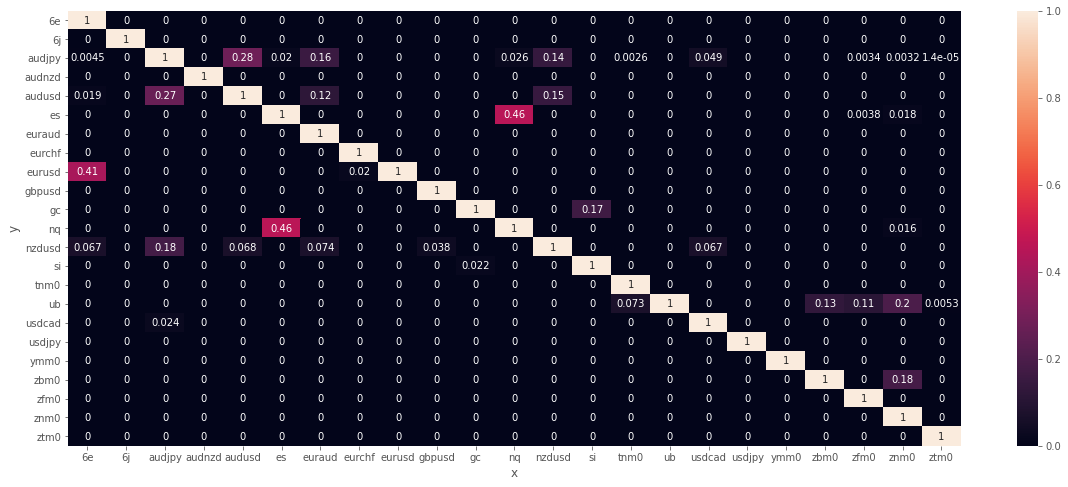

In [ ]:
plt.style.use('ggplot')
#import ppscore as pps
plt.figure(figsize=(20,8))
a = ppscore.matrix(df).pivot(columns='x', index='y', values='ppscore')

"""
PPS is better for finding patterns 
"""
sns.heatmap(a, annot=True)

From above PPS matrix, variable on the x-axis is used to predict the corresponding variable on the y-axis.

It shows that out-of-sample prediction of exact prce may not be easy. The only predictive relations that would have accomplished some reduction in mean absolute errors are those between 
- EURUSD & 6E
- AUDUSD & AUDJPY
- NZDUSD & AUDJPY
- NQ & ES


- score of 0 means that the column x cannot predict the column y better than a naive baseline model. 
- score of 1 means that the column x can perfectly predict the column y given the model. 
- score between 0 and 1 states the ratio of how much potential predictive power the model achieved compared to the baseline model.

In [ ]:
ppscore.score(df, 'es', 'eurusd')

{'baseline_score': 0.00012612114920000002,
 'case': 'regression',
 'is_valid_score': True,
 'metric': 'mean absolute error',
 'model': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'),
 'model_score': 0.0001344989653477652,
 'ppscore': 0,
 'x': 'es',
 'y': 'eurusd'}

In [ ]:
ppscore.score(df, 'eurusd', 'es')

{'baseline_score': 0.000407040323,
 'case': 'regression',
 'is_valid_score': True,
 'metric': 'mean absolute error',
 'model': DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'),
 'model_score': 0.00046835819695438823,
 'ppscore': 0,
 'x': 'eurusd',
 'y': 'es'}

## 1.3 Pearson correlation:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

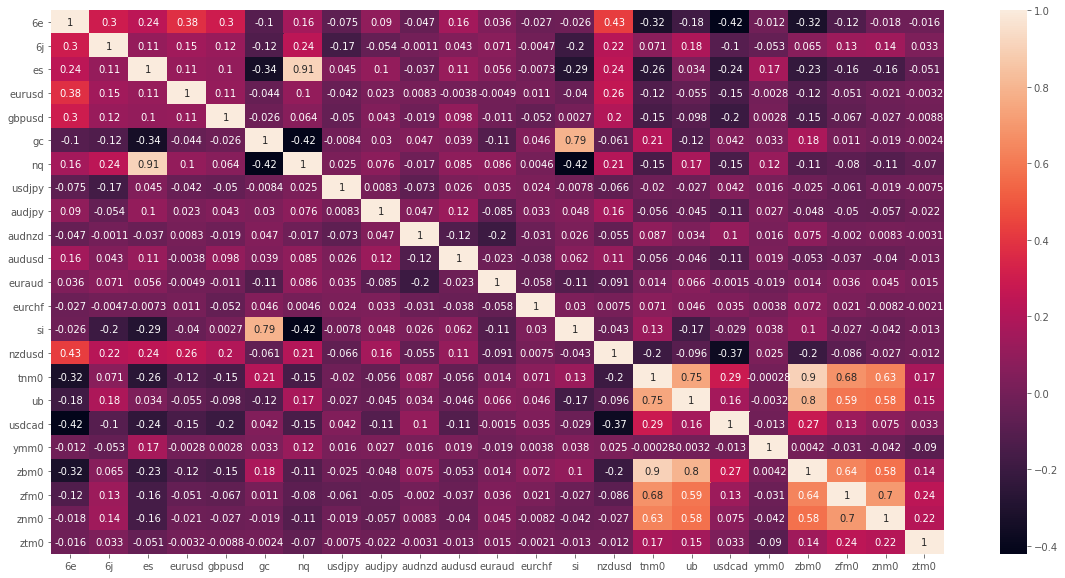

In [ ]:
pearsoncorr = df.corr(method='pearson')

"""
Pearson correlation matrix and plots show the bivariate relationship between the independent variables.
"""

# Set up the matplotlib figure
plt.figure(figsize=(20,10))
sns.heatmap(pearsoncorr, annot=True)
plt.show()

## 1.4 Calling VIF report:

- maximum level of VIF = 10 (Hair, J. F. Jr., Anderson, R. E., Tatham, R. L. & Black, W. C.;1995))
- maximum level of VIF = 5 (Ringle, Christian M., Wende, Sven, & Becker, Jan-Michael; 2015. SmartPLS 3. Bönningstedt: SmartPLS. Retrieved from http://www.smartpls.com)
- If VIF value exceeding 4.0, or by tolerance less than 0.2 then there is a problem with multicollinearity (Hair et al., 2010).


In [ ]:
X = df.assign(const=1)
"""
VIF starts at 1 and has no upper limit
VIF = 1, no correlation between the independent variable and the other variables
VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others
"""

# For each X, calculate VIF and save in dataframe
vif = DataFrame()
vif["features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.round(2)

,features,VIF Factor
0,6e,1.86
1,6j,1.40
2,es,8.06
3,eurusd,1.20
4,gbpusd,1.12
5,gc,3.07
6,nq,8.78
7,usdjpy,1.05
8,audjpy,1.07
9,audnzd,1.10


Dropping variables through iterative process starting with the variable having the largest VIF value because its trend is highly captured by other variables. 

Therefore, dropping one of the correlated features will help in bringing down the multicollinearity between correlated features:

In [ ]:
# dropping 'NQ' variable (vif = 8.78)
X = X.drop(['nq'],axis=1)

# For each X, calculate VIF and save in dataframe
vif = DataFrame()
vif["features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.round(2)

,features,VIF Factor
0,6e,1.84
1,6j,1.29
2,es,1.48
3,eurusd,1.20
4,gbpusd,1.12
5,gc,3.07
6,usdjpy,1.05
7,audjpy,1.07
8,audnzd,1.09
9,audusd,1.08


In [ ]:
# dropping 'ZBM0' (vif = 7.12)
X = X.drop(['zbm0'],axis=1)
# For each X, calculate VIF and save in dataframe
vif = DataFrame()
vif["features"] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.round(2)

,features,VIF Factor
0,6e,1.83
1,6j,1.28
2,es,1.46
3,eurusd,1.20
4,gbpusd,1.12
5,gc,3.03
6,usdjpy,1.05
7,audjpy,1.07
8,audnzd,1.09
9,audusd,1.08


correlation matrix (differenced data):
              6e        6j        es  ...      znm0      ztm0  const
6e      1.000000  0.296929  0.237993  ... -0.017836 -0.016099    NaN
6j      0.296929  1.000000  0.111082  ...  0.144331  0.033081    NaN
es      0.237993  0.111082  1.000000  ... -0.161263 -0.051423    NaN
eurusd  0.380402  0.149145  0.112710  ... -0.021435 -0.003209    NaN
gbpusd  0.300724  0.122631  0.104535  ... -0.026728 -0.008817    NaN
gc     -0.100848 -0.121750 -0.340552  ... -0.019485 -0.002384    NaN
usdjpy -0.074790 -0.167988  0.045411  ... -0.019438 -0.007492    NaN
audjpy  0.090335 -0.053593  0.103509  ... -0.057026 -0.021809    NaN
audnzd -0.046680 -0.001136 -0.036619  ...  0.008349 -0.003089    NaN
audusd  0.156150  0.042563  0.113781  ... -0.039653 -0.013108    NaN
euraud  0.035947  0.071023  0.056481  ...  0.044899  0.015210    NaN
eurchf -0.027484 -0.004735 -0.007332  ... -0.008165 -0.002080    NaN
si     -0.025943 -0.197612 -0.287417  ... -0.041559 -0.013344   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

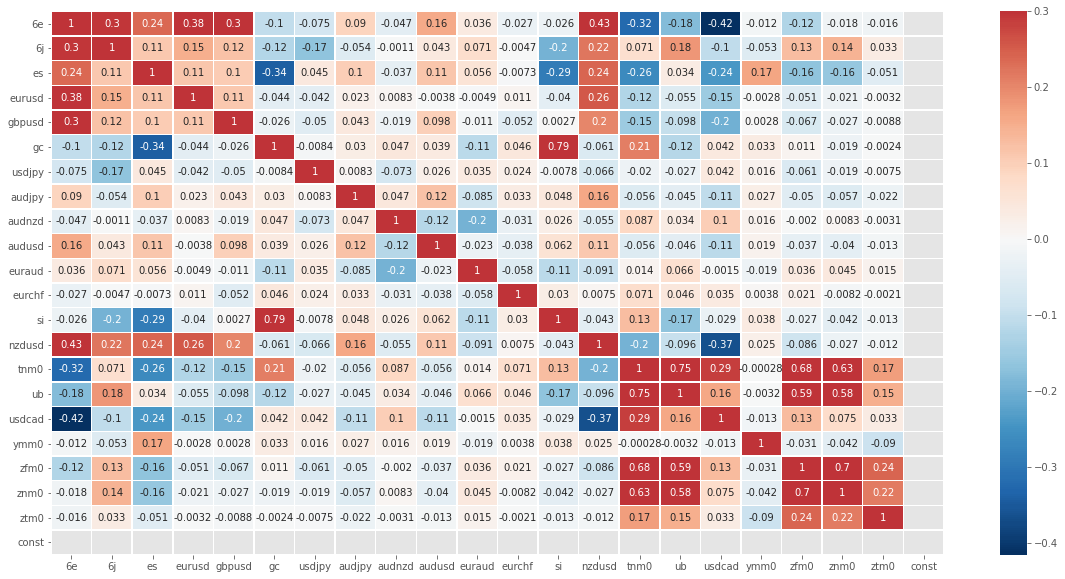

In [ ]:
# rechecking correlation on transformed data
#col = train_trans.copy()
print('correlation matrix (differenced data):')
print(X.corr())
pearsoncorr = X.corr(method='pearson')

"""
Pearson correlation matrix and plots show the bivariate relationship between the independent variables.
"""
plt.figure(figsize=(20,10))
sns.heatmap(pearsoncorr, xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',annot=True,linewidth=0.5,
            vmax=.3, center=0)
plt.show()

However, fitting out time series model with 32 dimensional series may pose many challenges primarily due to the large number of parameters involved. 

In VAR model, the number of parameters grows quadratically with the
dimension of the series. 

***Standard VAR models are rarely applied to time series with more than 10 dimensions (Zang. 2012, Fan et al. 2011)*** 

Therefore complexity reduction becomes an important aspect in fitting time series models to large dimensional series.

One way to reduce the domensionality is to perform principal component analysis.


# 2 Factor Analysis:
Here our goal is to model the interrelationships among the variables.

We need to select the right number of factors. Every factor contain certain number of variables and explains a certain variance in variables. 

**Adequacy checks:**

To check if factor analysis is feasible.  
 


## 2.1 Bartlett's test of Adequacy:
To check of intercorrelation between variables.  If factor analysis is an appropriate method to use, the correlation matrix and the identity matrix will not be the same, and the test will be significant. 



In [ ]:
chi_square_value,p_value = calculate_bartlett_sphericity(df)
"""
If the test found statistically insignificant, we should not employ a factor analysis.
"""
print(chi_square_value, p_value)

297571.4380926566 0.0


Here p-value = 0. 

The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix.

## 2.2 Kaiser-Meyer-Olkin (KMO) Test of Adequacy:
KMO test whether it is appropriate to use the variables for factor analysis.  
- It measures the suitability of data for factor analysis. 
- It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variable. 
- Lower proportion id more suitable for factor analysis. KMO values range between 0 and 1. 
- Value of KMO < 0.6 is considered inadequate.

In [ ]:
kmo_all, kmo_model=calculate_kmo(df)

"""
KMO is based on the more significant proportion of variance explained by factor will be selected. 
The statistic is based on eigen value criteria to determin the number of factors. 
Eigenvalue > 1 will be considered as selection criteria for the feature.
"""
print(kmo_model)

0.7528919186387111


/usr/local/lib/python3.6/dist-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


The overall KMO for our data is 0.75 indicateing that we can proceed with factor analysis. Our data meet Adequacy test

## 2.3 Choosing the Number of Factors:




In [ ]:
# Creating FA object to performing FA

"""
preliminary factor analysis without any rotation.  
This step is to aid the decision about the number of factors used in a solution.  
Here, we get the eigenvalues of our initial solution, and plot them on a scree plot.  
We can find the number of generated factors vs. the eigenvalues.  
Eigenvalues >= 1 should be considered when choosing the number of factors.  
A factor with an eigenvalue of 1 accounts for at least the variance of a single feature. 
"""

# Exploratory factor analysis (EFA):
fa = FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=6, rotation=None, rotation_kwargs={},
               use_smc=True)
fa.fit(df)

"""
eigenvalues represent variance explained each factor from the total variance. 
"""
eigen_values, vectors = fa.get_eigenvalues()
print(DataFrame(eigen_values))

           0
0   4.298783
1   2.891968
2   2.003255
3   1.424634
4   1.256921
5   1.079422
6   1.047786
7   0.974752
8   0.902287
9   0.881396
10  0.876888
11  0.838671
12  0.815364
13  0.729831
14  0.694359
15  0.571553
16  0.519011
17  0.409322
18  0.281529
19  0.197103
20  0.156752
21  0.087959
22  0.060454


For 6-factors eigenvalues > one. 

It means we need to choose only 6 factors (or unobserved variables).
#### 2.3.1 Scree plot:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

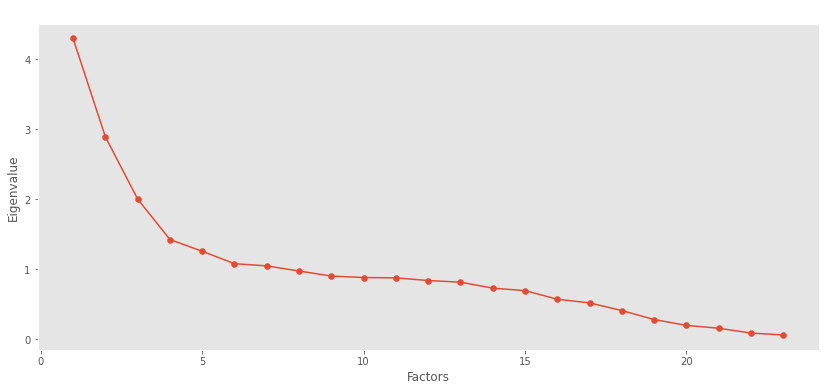

In [ ]:
# Create scree plot using matplotlib
plt.figure(figsize=(14,6))
plt.scatter(range(1, df.shape[1]+1), eigen_values)
plt.plot(range(1, df.shape[1]+1), eigen_values)

"""
scree plot shows the number of factors where the curve makes an elbow.
"""
plt.title('Scree Plot'); plt.xlabel('Factors');
plt.ylabel('Eigenvalue'); plt.grid()
plt.show()

The scree plot method draws a straight line for each factor and its eigenvalues. Number eigenvalues > one considered as the number of factors.

Based on the scree plot, we choose a solution with 6 factors. We can start rotating these factors.  Since FA is an iterative method, we will stick to a general process:  

### 2.3.2 FA with Varimax rotation:




In [ ]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=6, rotation="varimax", method='minres', use_smc=True)
fa.fit(df)

FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=6, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

fa_loadings= DataFrame(fa.loadings_)
fa_loadings

,0,1,2,3,4,5
0,-0.103533,0.752627,-0.050598,-0.007931,0.222788,-0.094504
1,0.157130,0.264470,-0.129929,0.066486,0.497217,-0.101320
2,-0.122591,0.285007,-0.259424,0.839356,-0.055744,-0.060740
3,-0.042794,0.351856,-0.037827,0.007128,0.202071,0.018209
4,-0.057101,0.347907,-0.005900,-0.002734,0.070324,-0.019588
5,0.010842,-0.038633,0.886253,-0.110448,0.000614,0.100311
6,-0.039264,0.164316,-0.358093,0.897477,0.131816,-0.073432
7,-0.027065,-0.077992,-0.004844,0.061999,-0.237998,-0.078770
8,-0.018735,0.185265,0.037976,0.101326,-0.140809,0.184047
9,-0.001616,-0.101180,0.002863,0.002450,0.153343,0.389352


### 2.3.2 Factor loadings:

In [ ]:
fa_loadings = fa_loadings.transpose()

"""
factor loading shows the relationship of each variable to the underlying factor. 
It shows the variance explained by the variables.
Square of each loading represents the proportion of variance.
"""
# adding column name to the respective columns 
fa_loadings.columns =df.columns
fa_loadings.transpose()

,0,1,2,3,4,5
6e,-0.103533,0.752627,-0.050598,-0.007931,0.222788,-0.094504
6j,0.157130,0.264470,-0.129929,0.066486,0.497217,-0.101320
es,-0.122591,0.285007,-0.259424,0.839356,-0.055744,-0.060740
eurusd,-0.042794,0.351856,-0.037827,0.007128,0.202071,0.018209
gbpusd,-0.057101,0.347907,-0.005900,-0.002734,0.070324,-0.019588
gc,0.010842,-0.038633,0.886253,-0.110448,0.000614,0.100311
nq,-0.039264,0.164316,-0.358093,0.897477,0.131816,-0.073432
usdjpy,-0.027065,-0.077992,-0.004844,0.061999,-0.237998,-0.078770
audjpy,-0.018735,0.185265,0.037976,0.101326,-0.140809,0.184047
audnzd,-0.001616,-0.101180,0.002863,0.002450,0.153343,0.389352


The higher a factor loading, the more important a variable is for said factor. A loading cut-off of 0.5 will be used here. This cut-off determines which variables belong to which factor:

- factor 1 has high factor loadings (> 0.5) for **TNM0, UB, ZBM0, ZFM0 & ZNM0**
- factor 2 has high factor loadings (> 0.5) for **6E & NZDUSD**
- factor 3 has high factor loadings (> 0.5) for **SI & GC**
- factor 4 has high factor loadings (> 0.5) for **ES & NQ**




### 2.3.3 Communalities:

In [ ]:
# proportion of each variable's variance explained by the factors 
communalities = DataFrame(fa.get_communalities()).transpose()
# adding column name to the respective columns 
communalities.columns =df.columns
communalities.transpose()


,0
6e,0.638355
6j,0.373427
es,0.874874
eurusd,0.168280
gbpusd,0.129671
gc,0.809316
nq,0.985005
usdjpy,0.073530
audjpy,0.100084
audnzd,0.185363


In [ ]:
# Get variance of each factors
DataFrame(fa.get_factor_variance())

,0,1,2,3,4,5
0,3.451225,1.998173,1.863811,1.695407,0.569724,0.536203
1,0.150053,0.086877,0.081035,0.073713,0.024771,0.023313
2,0.150053,0.236930,0.317966,0.391679,0.416450,0.439763


# 3 PCA:
Ref: Xiao Zhong, David Enke, 2017

Performing PCA on dependent variables won't change the predictive power, as shown above.

**Assumption of PCA**

different components need to be distinct from each other to be interpretable otherwise they only represent random directions 

**Objective**
find the best line under the minimum error and maximum variance constraints


In [ ]:
#A = np.array(df)

#  mean of each column
#M = mean(A.T, axis=1)
#print(DataFrame(M))

In [ ]:
# center columns by subtracting column means
#C = A - M
#print(DataFrame(C))

In [ ]:
# covariance matrix of centered matrix
#V = cov(C.T)
#print(DataFrame(V)); print()

In [ ]:
# eigendecomposition of covariance matrix
#eigen_values, eigen_vectors = eig(V)
#print(DataFrame(eigen_vectors)); print();
#print(DataFrame(eigen_values)); print()

In [ ]:
# project data
#P = eigen_vectors.T.dot(C.T)
#print(DataFrame(P.T))

In [ ]:
cor_matrix = np.corrcoef(df.T)
eig_values, eig_vectors = np.linalg.eig(cor_matrix)
print('Eigenvectors \n%s' %eig_vectors)
print('\nEigenvalues \n%s' %eig_values)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Eigenvectors 
[[-2.25777602e-01  1.87258266e-01 -3.92743157e-01  1.37269487e-01
   4.48350827e-02  2.56751608e-02 -5.38687136e-02 -1.23956021e-01
   1.78925830e-01 -1.23083510e-02  6.56796621e-01 -3.99501726e-01
   1.57975559e-01  3.36620857e-02  5.95245442e-02 -1.70368454e-01
  -1.16600163e-01  9.37887260e-02 -8.47116571e-02  2.69206791e-02
   8.00665832e-02 -2.93559567e-02  2.36615834e-02]
 [-8.92007045e-03  2.87060755e-01 -1.99755517e-01  2.02710496e-01
  -8.30203363e-02 -3.10869905e-02 -3.58555175e-02  1.03776401e-01
  -4.21350280e-02  1.31108019e-01 -1.92045828e-01  1.15917414e-01
   2.96005553e-01  2.39325544e-01  1.92445617e-03  3.99984588e-01
  -5.41042012e-01 -2.87568540e-01 -3.91204585e-02  3.47266782e-02
   3.13952419e-03 -2.53424645e-01  6.77674701e-03]
 [-2.19122000e-01  3.65260633e-01  1.32395960e-01 -3.62346383e-01
  -6.72296482e-01 -9.49365844e-02 -8.85541845e-02  4.81711630e-03
  -4.71893334e-02 -4.50885673e-02 -4.91061018e-02 -2.01821295e-01
   4.24996528e-02  7.04391

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

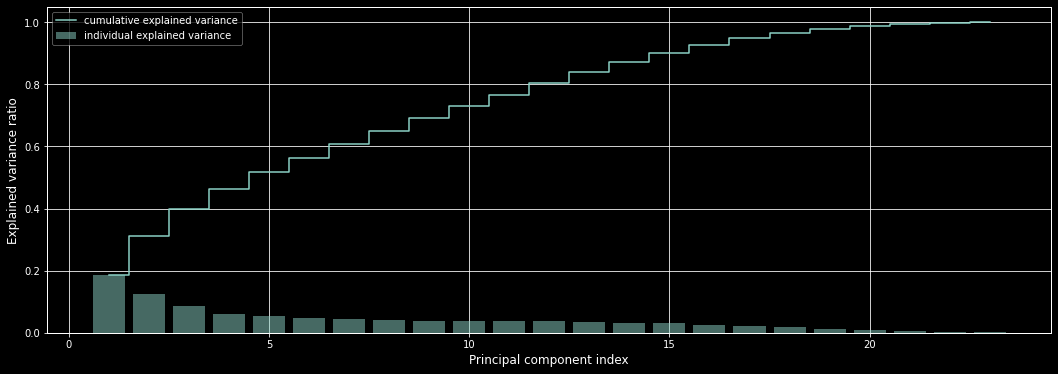

In [ ]:
plt.style.use('dark_background')
tot = sum(eigen_values)
var_exp = [(i / tot) for i in sorted(eigen_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# Percentage of inertia carried by each axis
plt.figure(figsize=(18,6))
plt.bar(range(1,24), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,24), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

- plot indicates that the 1st principal component alone accounts for
approximately 25% of the variance. 

- first two principal components combined explain almost 60 % of the variance in the dataset

In [ ]:
pca = PCA()

df_reduced = pca.fit_transform(df)

#print(df_reduced.components_)

# Variance (% cumulative) explained by the principal components
v1 = DataFrame(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
print(v1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

        0
0   25.04
1   38.92
2   50.29
3   59.14
4   67.22
5   73.07
6   78.21
7   83.03
8   86.93
9   89.78
10  92.38
11  94.65
12  96.20
13  97.63
14  98.53
15  99.17
16  99.49
17  99.68
18  99.85
19  99.92
20  99.96
21  99.98
22  99.99


- First 10 components explained 89.78% of the variance in the data
- First 15 components explained 98.53% of the variance in the data

In [ ]:
# Scatter
#fig, ax = model.scatter()

# biplot with the number of features
#fig, ax = model.biplot(n_feat=23)

In [ ]:
# Creating a PCA that will retain 99% of variance
pca = PCA(n_components=0.99, whiten=True)
# performing PCA
reduced_pca = pca.fit_transform(df)
# results
print("Original number of features:", df.shape[1])
print("Reduced number of features:", reduced_pca.shape[1])

Original number of features: 23
Reduced number of features: 16


<IPython.core.display.Javascript object>

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [99.0%] explained variance using the [23] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [16] that covers the [99.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


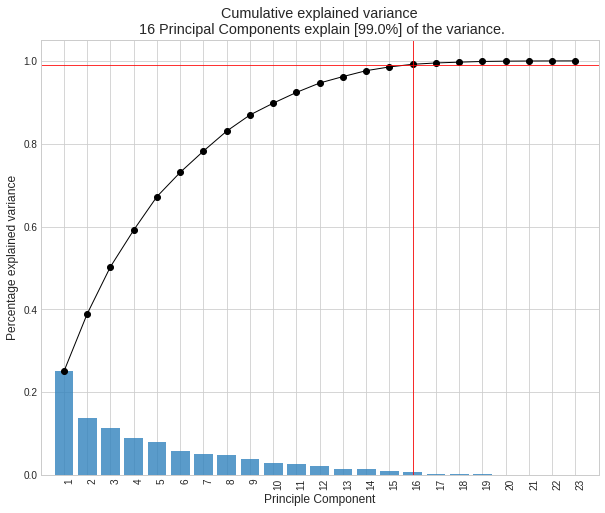

<Figure size 432x288 with 0 Axes>

In [ ]:
from pca import pca
plt.style.use('seaborn-whitegrid')

# Initialize to reduce the data up to the number of componentes that explains 99% of the variance.
model = pca(n_components = 0.99)
# Fit transform
results = model.fit_transform(df)

# Plot explained variance
fig, ax = model.plot()

In [ ]:
# Variance (% cumulative) explained by the principal components
#v1 = DataFrame(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(v1)

**INFERENCE**
- 1st component is linear combination of original predictor variables capturing the maximum variance in the data set. It determines the direction of highest variability in the data. Larger the variability captured in first component, larger the information captured by component. It results in a line which is closest to the data (minimizes the sum of squared distance between a data point and the line).
- 2nd component is linear combination of original predictors capturing the remaining variance in the data set and is uncorrelated with 1st. 1st and 2nd are uncorrelated.
- the succeeding components follow similar concept of capturing the remaining variation without being correlated with the previous component. 

***n * p dimensional space min (n-1, p) component can be formed***

In [ ]:
def get_important_features(transformed_features, components_, columns):
    """
    This function will return the most "important" 
    features so we can determine which have the most
    effect on multi-dimensional scaling
    """
    num_columns = len(columns)

    # Scale the principal components by the max value in
    # the transformed set belonging to that component
    xvector = components_[0] * max(transformed_features[:,0])
    yvector = components_[1] * max(transformed_features[:,1])

    # Sort each column by it's length. These are your *original*
    # columns, not the principal components.
    important_features = { columns[i] : math.sqrt(xvector[i]**2 + yvector[i]**2) for i in range(num_columns) }
    important_features = sorted(zip(important_features.values(), important_features.keys()), reverse=True)
    print ("Features by importance:\n", important_features)

DataFrame(get_important_features(df_reduced, pca.components_, df.columns.values))

Features by importance:
 [(0.07355650356773726, 'nq'), (0.056303609790940866, 'si'), (0.053271082753840245, 'es'), (0.03826363288236868, 'euraud'), (0.036385631649338564, 'gc'), (0.02039871559189907, 'audjpy'), (0.01324011863380163, 'audusd'), (0.008203046068107104, 'nzdusd'), (0.006847509940386626, 'ymm0'), (0.00581479896883121, 'ub'), (0.00447571416970303, 'audnzd'), (0.004435447567517316, 'usdcad'), (0.004114330709709912, 'eurusd'), (0.0038835244313645823, 'zbm0'), (0.0037366154568486657, 'gbpusd'), (0.003304205172947304, '6j'), (0.003121378812461428, 'eurchf'), (0.0029767353852806133, 'tnm0'), (0.0028525966996422246, '6e'), (0.0018302535166039799, 'usdjpy'), (0.000781777216925222, 'znm0'), (0.00041617098149790383, 'zfm0'), (0.00016338475821673842, 'ztm0')]


""


In [ ]:
# variance—and the covariance—is unaffected by centering the data
centered_data = df - df.mean()
print(np.allclose(np.cov(df, rowvar=False), np.cov(centered_data, rowvar=False)))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

True


In [ ]:
components = DataFrame(pca.components_, columns = df.columns)
components

,6e,6j,es,eurusd,gbpusd,gc,nq,usdjpy,audjpy,audnzd,audusd,euraud,eurchf,si,nzdusd,tnm0,ub,usdcad,ymm0,zbm0,zfm0,znm0,ztm0
0,-0.023282,-0.028949,-0.460012,-0.034402,-0.025992,0.315378,-0.641721,-0.015546,-0.040328,0.023506,-0.044360,-0.153309,0.014347,0.484850,-0.058322,0.025353,-0.047873,0.033039,-0.046598,0.032787,0.002640,0.004615,0.001137
1,-0.022951,0.006848,-0.221796,-0.027619,-0.049192,-0.136148,-0.209896,0.010313,-0.427050,-0.077164,-0.263040,0.731956,-0.057190,-0.250511,-0.103901,0.016148,0.044195,0.050771,-0.093308,0.023608,0.006197,0.012460,0.002148
2,-0.030387,0.003225,-0.168316,-0.009667,-0.047793,-0.247813,-0.128021,-0.046024,-0.313184,0.110455,-0.400130,-0.629225,0.031327,-0.455823,-0.040078,0.004853,0.037080,0.056659,-0.083725,0.008471,0.003888,0.007564,0.001366
3,0.001606,-0.004032,-0.276156,-0.013821,-0.001386,-0.231257,-0.291975,-0.005594,0.752033,-0.005500,0.103300,0.102504,-0.017133,-0.409395,0.011948,-0.005663,-0.002383,0.008761,-0.172385,-0.008753,0.002713,0.006752,0.001813
4,0.017924,0.014052,-0.119662,-0.016888,0.055721,-0.121615,-0.136495,0.010259,-0.374072,-0.103129,0.839918,-0.113874,-0.158868,-0.201458,0.004403,-0.012467,-0.022102,-0.009203,-0.110599,-0.020925,0.000354,0.002629,0.001058
5,-0.022116,-0.003616,-0.036998,-0.025640,-0.091925,0.000792,0.004380,0.177537,-0.048657,-0.102005,0.135386,0.025447,0.952550,-0.048767,-0.035595,0.034069,0.078655,0.042164,-0.048923,0.056021,0.005911,0.006554,0.000982
6,0.044972,0.041624,0.078417,0.087341,0.091503,0.057284,0.130060,-0.302717,-0.030462,0.004674,-0.054447,0.003935,0.048037,0.136265,0.091153,-0.016986,-0.018522,-0.062151,-0.907693,-0.026868,-0.001452,-0.002707,0.003602
7,0.034417,0.053926,-0.056578,0.071867,0.091890,-0.016708,-0.039698,-0.902730,-0.013593,0.071475,0.065350,0.061938,0.186935,-0.049592,0.082401,0.013478,0.041886,-0.031694,0.318017,0.023503,0.006918,0.007191,-0.000571
8,-0.146424,-0.000782,-0.050234,-0.293545,-0.429696,0.109645,0.178118,-0.110276,0.056841,0.286574,0.123416,-0.000029,-0.110814,0.018730,-0.322285,0.190552,0.476957,0.234949,-0.096144,0.315040,0.038967,0.056458,0.005996
9,0.055266,0.025909,-0.033683,0.201900,0.318779,0.015157,-0.022930,0.164007,-0.047888,0.889168,0.084304,0.115122,0.086041,-0.032235,0.052744,0.000449,-0.022219,0.004927,0.002535,-0.007760,-0.004366,0.000583,-0.000144


In [ ]:
#pd.options.display.float_format = "{:.2f}".format
#orig_cov = np.cov(centered_data, rowvar=False)
#print(DataFrame(orig_cov)); print()
#print((np.diag(orig_cov).sum()))
# 0.00000779636

In [ ]:
#plt.figure(figsize=(14,6))
#plt.plot(v1); 
#plt.xlabel('Number of component'); plt.ylabel('explained variance(%)')
#plt.show()

# Percentage of inertia carried by each axis
#plt.figure(figsize=(18,7))
#plt.subplot(1,2,1)
#variance = pca.explained_variance_ratio_*100
#plt.bar(range(1,24),variance)
#plt.xlabel("rank of the inertia axis")
#plt.ylabel("percentage of inertia")
#plt.title("Percentage of component inertia"); plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

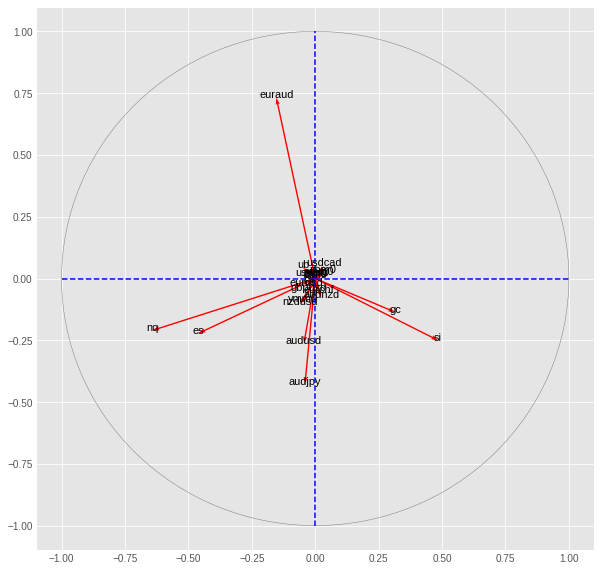

In [ ]:
plt.style.use('ggplot')
# Circle of correlations 

# Num of variables
features = df.columns.tolist()

# Matrix of components and their coordinates on variables
pcs = pca.components_

fig, ax = plt.subplots(figsize=(10,10))

# Display of arrows (we want to display the variables on the first 6 components - 
# the lines are the eigenvectors and columns the initial variables)
plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]), pcs[0,:], 
           pcs[1,:], width=0.0025, angles='xy', scale_units='xy', scale=1, color="red")

# Cricle display
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='gray')
fig = plt.gcf()
ax = fig.gca()
ax.add_artist(circle)

# The main axes are displayed
plt.plot([-1, 1], [0, 0], color='b',ls='--')
plt.plot([0, 0], [-1, 1], color='b', ls='--')  

for i,(x, y) in enumerate(pcs[[0,1]].T):
       plt.text(x,y, df.columns[i], fontsize='11', ha='center', color="black")

- +vely correlated variables are grouped together.
- -vely correlated variables are positioned on opposite sides of the plot origin (opposed quadrants).
- The distance between variables and the origin measures the quality of the variables on the factor map. 
- Variables that are away from the origin are well represented on the factor map.

**Here selected features are "NQ, ES, AUDJPY, AUDUSD, GC, SI, EURUSD"**

## 3.1 Screeplot:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

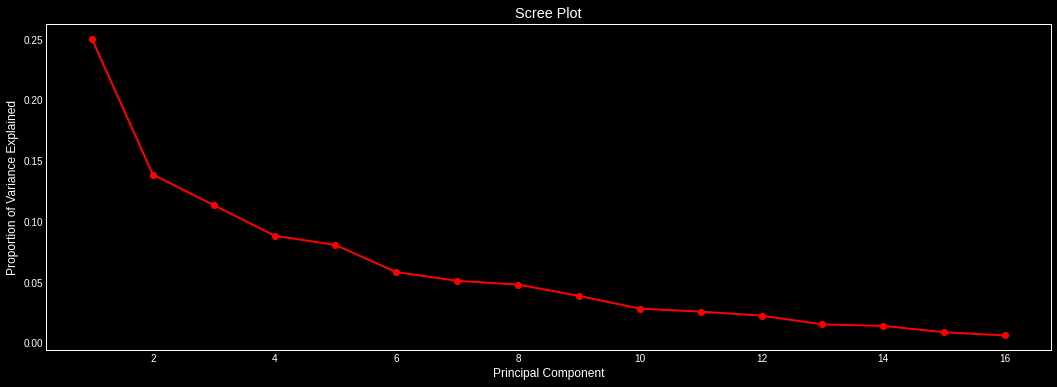

In [ ]:
plt.style.use('dark_background')
plt.figure(figsize=(18,6))
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot'); plt.grid()
plt.xlabel('Principal Component'); plt.ylabel('Proportion of Variance Explained')
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

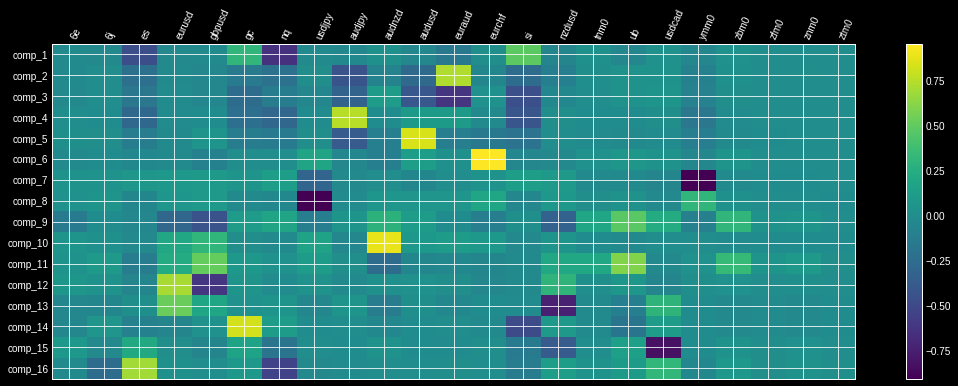

'\nIt’s actually difficult to understand how correlated the original features are from this plot \n'

In [ ]:
# correlation between the features and the principal component itself.
plt.figure(figsize=(18,6))
plt.matshow(pca.components_, cmap='viridis',fignum=1, aspect='auto')
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],['comp_1','comp_2','comp_3', 'comp_4', 'comp_5',
                    'comp_6', 'comp_7', 'comp_8', 'comp_9','comp_10', 'comp_11',
                    'comp_12','comp_13', 'comp_14', 'comp_15', 'comp_16'], fontsize=10)

"""features mixed up to create the components"""

plt.colorbar()
plt.xticks(range(len(df.columns)),df.columns,rotation=65,ha='left')
plt.show()
#plt.tight_layout()

"""
It’s actually difficult to understand how correlated the original features are from this plot 
"""
 

**Difference between PCA & FA:**
- PCA explain the maximum amount of variance while FA explains the covariance in data.
- PCA are fully orthogonal to each other whereas FA does not require factors to be orthogonal.
- PCA is a linear combination of the observed variable while in FA, the observed variables are linear combinations of the unobserved variable or factor.
- PCA components are uninterpretable. In FA, underlying factors are labelable and interpretable.
- PCA is a kind of dimensionality reduction method whereas FA is the latent variable method.
- PCA is a type of factor analysis. PCA is observational whereas FA is a modeling technique.



# **3 Conclusion:**

- The Pearson correlation matrix of predictors, as above, also indicate the presence of multicollinearity. 
- However, Pearson correlation talks about bivariate linear relationship whereas multicollinearity are multivariate, therefore, we shall depend of VIF for our on-going investigation.
- To avoid curse of dimensionality and complexity in thye model, I shall dig in more details. For now, PCA suggests that with 10 components, the model can explain over 90% of variance in data which is encouraging.

***we have reduced number of features from FA & PCA are about 6 to 10. We will use "RULE OF 10" for further analysis*** 

---

